## 1. PyTorch ve GPU Kontrolü

bilgisayarımızda CUDA yani GPU desteği olup olmadığını kontrol ettik.  
Eğer CUDA destekliyse, kullanılan ekran kartının (GPU'nun) adını da ekrana yazdırdık.

Bu şekilde, kodlarımızı GPU ile hızlandırıp hızlandıramayacağımızı baştan görmüş olduk.


In [1]:
import torch
print("PyTorch sürümü:", torch.__version__)
print("CUDA kullanılabilir mi?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Kullanılan GPU:", torch.cuda.get_device_name(0))


PyTorch sürümü: 2.7.0+cu118
CUDA kullanılabilir mi? True
Kullanılan GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


## 2. Veri Setinin Hazırlanması ve Karakter Kodlama


 **Veri okuma:**  
  `dataset.csv` dosyasını okuduk ve bir pandas DataFrame olarak aldık.

 **Uzunluk filtresi:**  
  Hem yanlış hem de doğru kelimelerin uzunluğunu 30 karakterden fazla olanları eledik.  
  Çok uzun kelimeleri çıkardık, çünkü model bunları öğrenmekte zorlanabilir.

 **Aynı eşleşmeleri kaldırdık:**  
  Aynı yanlış-doğru kelime çiftlerinden tekrar edenleri sildik, sadece benzersiz olanlar kaldı.

 **Karakter tablosu:**  
  Veri setinde geçen tüm harfleri bir araya getirdik ve sıraladık.  
  Sonra özel olarak `<pad>`, `<s>` (başlangıç) ve `<e>` (bitiş) karakterlerini de ekledik.  
  Bu karakterlerin her birine bir sayı verdik (char2idx ve idx2char sözlükleriyle).

 **Alfabe boyutu ve maksimum kelime uzunluğu:**  
  Kaç farklı karakter kullanıldığını (VOCAB_SIZE) ve en uzun kelimenin kaç karakter olduğunu bulduk (MAX_KELIME).

 **Kelime kodlama fonksiyonu:**  
  Her kelimeyi başına `<s>`, sonuna `<e>` karakterleri ekleyerek sayıya çevirdik.  
  Eğer bir kelime kısa ise, sonuna `<pad>` ekleyerek hep aynı uzunlukta olmalarını sağladık.

 **Veri encoding:**  
  Tüm yanlış ve doğru kelimeleri bu şekilde sayıya çevirdik.  
  Son olarak veri şekillerini ekrana yazdırdık.

Böylece modelimiz için kelimeler artık harf harf değil, sayı dizisi olarak hazırlandı.


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('dataset.csv', sep=';')

UZUNLUK_SINIRI = 30
df = df[(df['yanlis_kelime'].str.len() <= UZUNLUK_SINIRI) & (df['dogru_kelime'].str.len() <= UZUNLUK_SINIRI)]
df = df[df['yanlis_kelime'] != df['dogru_kelime']]
df = df.drop_duplicates(subset=['yanlis_kelime', 'dogru_kelime']).reset_index(drop=True)
print("Kalan veri:", len(df))

karakterler = set(''.join(df['yanlis_kelime']) + ''.join(df['dogru_kelime']))
karakterler = sorted(list(karakterler))
karakterler = ['<pad>', '<s>', '<e>'] + karakterler
char2idx = {ch: i for i, ch in enumerate(karakterler)}
idx2char = {i: ch for ch, i in char2idx.items()}
VOCAB_SIZE = len(char2idx)
MAX_KELIME = max(df['yanlis_kelime'].str.len().max(), df['dogru_kelime'].str.len().max())
print("Alfabe boyutu:", VOCAB_SIZE)
print("MAX_KELIME:", MAX_KELIME)

def encode_word(word, maxlen=MAX_KELIME):
    seq = [char2idx['<s>']] + [char2idx.get(ch, char2idx['<pad>']) for ch in word] + [char2idx['<e>']]
    seq = seq[:maxlen+2]
    if len(seq) < maxlen+2:
        seq += [char2idx['<pad>']] * (maxlen + 2 - len(seq))
    return seq

yanlis_encoded = np.array([encode_word(w) for w in df['yanlis_kelime']])
dogru_encoded  = np.array([encode_word(w) for w in df['dogru_kelime']])
print("Encoding tamam. Yanlış şekli:", yanlis_encoded.shape, "Doğru şekli:", dogru_encoded.shape)


Kalan veri: 8848261
Alfabe boyutu: 66
MAX_KELIME: 30
Encoding tamam. Yanlış şekli: (8848261, 32) Doğru şekli: (8848261, 32)


## 3. Veriyi PyTorch için Hazırlama ve Dataloader Kullanımı

 modelin eğitimi için veri hazırlığı

 **PyTorch Dataset Sınıfı:**  
  Önce kendi veri seti sınıfımızı (`SpellDataset`) yazdık.  
  Burada hem yanlış hem de doğru kelimeleri PyTorch tensörlerine çevirdik.  
  Bu sınıf sayesinde, PyTorch modeline kolayca veri sağlayabiliyoruz.

**Dataloader ile Veri Yükleme:**  
  Çok büyük veriyle çalıştığımız için, hepsini birden RAM’e yüklemek yerine parça parça (batch halinde) modele gönderiyoruz.  
  `BATCH_SIZE` ile her defasında 512 kelimeyi bir arada işliyoruz.  
  Dataloader ile veriler GPU'ya hızlıca gönderilebiliyor ve eğitim sırasında her batch rasgele seçiliyor .

 **Batch Kontrolü:**  
  Kodun sonunda, bir batch çekip boyutlarına baktık.  
  Böylece modelimizin veri şekillerinin doğru olup olmadığını gördük.

Sonuç olarak, eğitim sırasında model her defasında 512 tane yanlış ve doğru kelime çiftiyle çalışacak şekilde ayarlandı.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpellDataset(torch.utils.data.Dataset):
    def __init__(self, input_seqs, target_seqs):
        self.input_seqs = torch.tensor(input_seqs, dtype=torch.long)
        self.target_seqs = torch.tensor(target_seqs, dtype=torch.long)
    def __len__(self):
        return len(self.input_seqs)
    def __getitem__(self, idx):
        return self.input_seqs[idx], self.target_seqs[idx]

BATCH_SIZE = 512          # büyük veri için GPU'da daha hızlı eğitim
train_dataset = SpellDataset(yanlis_encoded, dogru_encoded)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  
    pin_memory=True
)

for xb, yb in train_loader:
    print("Batch input shape:", xb.shape)
    print("Batch target shape:", yb.shape)
    break


Batch input shape: torch.Size([512, 32])
Batch target shape: torch.Size([512, 32])


## 4. LSTM Tabanlı Modelin Kurulması

 yanlış yazılmış kelimeyi doğruya çevirmek için kullanılacak model

- **Modelin Temeli:**  
  Modelimiz, karakter karakter çalışan bir LSTM (uzun-kısa süreli bellekli sinir ağı) tabanlı seq2seq (sıralıdan sıralıya) modelidir.  
  Yani, model yanlış yazılmış bir kelimeyi okur ve doğru halini karakter karakter üretir.

- **Katmanlar:**  
  - **Embedding Katmanı:**  
    Giren her harfi bir sayı vektörüne dönüştürür, böylece model harfler arasında anlamlı bir ilişki öğrenebilir.
  - **Encoder LSTM:**  
    Tüm yanlış kelimeyi okur ve özetini hafızasında tutar.
  - **Decoder LSTM:**  
    Bu özetle başlayıp, adım adım doğru kelimeyi üretir.
  - **Linear Katman (fc):**  
    Her adımda çıkan sonucu tekrar karaktere çevirir.

- **Teacher Forcing:**  
  Eğitim sırasında modelin bazen kendi ürettiği karakteri, bazen de doğrusunu kullanarak öğrenmesi sağlanır (teacher_forcing_ratio ile).  
  Böylece daha hızlı ve sağlam öğrenir.

- **Cihaz Seçimi:**  
  Modeli GPU varsa GPU’da, yoksa CPU’da çalışacak şekilde kurduk.





In [13]:
import torch.nn as nn

class Seq2SeqLSTM(nn.Module):
    def __init__(self, vocab_size, emb_size=256, hidden_size=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.encoder = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )
        self.decoder = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        device = src.device
        embedded_src = self.embedding(src)
        _, (hidden, cell) = self.encoder(embedded_src)

        batch_size, trg_len = trg.size()
        outputs = torch.zeros(batch_size, trg_len, self.fc.out_features).to(device)
        input_token = trg[:, 0]

        for t in range(1, trg_len):
            embedded = self.embedding(input_token).unsqueeze(1)
            output, (hidden, cell) = self.decoder(embedded, (hidden, cell))
            pred = self.fc(output.squeeze(1))
            outputs[:, t] = pred

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = pred.argmax(1)
            input_token = trg[:, t] if teacher_force else top1
        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqLSTM(
    vocab_size=VOCAB_SIZE,
    emb_size=256,
    hidden_size=512,
    num_layers=3,
    dropout=0.3
).to(device)

print(model)


Seq2SeqLSTM(
  (embedding): Embedding(66, 256, padding_idx=0)
  (encoder): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (decoder): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=512, out_features=66, bias=True)
)


## 5. Modelin Eğitimi ve Değerlendirme Metrikleri

 modelimizi eğitiyoruz ve her epoch  sonunda çeşitli değerlendirme sonuçlarını gösteriliyor

- **Kayıp Fonksiyonu ve Optimizasyon:**  
  Modelin yaptığı hataları ölçmek için çapraz entropi (CrossEntropyLoss) kullandık.  
  Modelin ağırlıklarını güncellemek için Adam optimizasyonunu tercih ettik.

- **Epoch Döngüsü:**  
  Modeli toplam 5 tur boyunca eğittik.  
  Her turda tüm veriyi parça parça (batch) modelden geçirip, hatayı hesaplayıp modelin öğrenmesini sağladık.

- **Doğruluk Hesaplama:**  
  Her batch'te modelin ne kadar doğru tahmin yaptığını hesapladık ve epoch sonunda ortalama doğruluğu kaydettik.

- **F1 Skorları:**  
  Sadece doğruluk değil, aynı zamanda F1-macro ve F1-micro gibi skorları da hesapladık.  
  Böylece modelin hem yaygın hem de nadir karakterleri ne kadar iyi öğrendiğini gördük.

- **Exact Match (Kelime Tam Doğru):**  
  Ayrıca, modelin tahmin ettiği kelimenin harfi harfine tamamen doğru olup olmadığını da ölçtük.

- **Eğitim Sonuçları:**  
  Her epoch sonunda ekrana kayıp (loss), doğruluk (accuracy), F1 skorları ve tam kelime başarısını yazdırdık.  
  Modelin ağırlıklarını da dosya olarak kaydettik (ileride tekrar kullanmak için).




In [ ]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score

criterion = nn.CrossEntropyLoss(ignore_index=char2idx['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    total = 0
    correct = 0

    preds_all = []
    trues_all = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for xb, yb in pbar:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        output = model(xb, yb, teacher_forcing_ratio=0.5)

        output_reshaped = output[:, 1:].reshape(-1, VOCAB_SIZE)
        yb_reshaped = yb[:, 1:].reshape(-1)
        loss = criterion(output_reshaped, yb_reshaped)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = output.argmax(dim=2).detach().cpu().numpy()
        y_true = yb.detach().cpu().numpy()
        preds_all.append(preds)
        trues_all.append(y_true)

        mask = (yb != char2idx['<pad>'])
        correct += (output.argmax(dim=2) == yb).masked_select(mask).sum().item()
        total += mask.sum().item()
        pbar.set_postfix({'Loss': f"{loss.item():.4f}", 'Acc': f"{(correct/total):.4f}"})

    avg_loss = epoch_loss / len(train_loader)
    acc = correct / total

    preds_all = np.concatenate(preds_all, axis=0)
    trues_all = np.concatenate(trues_all, axis=0)

    mask = trues_all != char2idx['<pad>']
    preds_flat = preds_all[mask]
    trues_flat = trues_all[mask]

    f1_macro = f1_score(trues_flat, preds_flat, average='macro')
    f1_micro = f1_score(trues_flat, preds_flat, average='micro')
    acc_flat = accuracy_score(trues_flat, preds_flat)

    exact_match = np.mean(
        [np.array_equal(p, t) for p, t in zip(preds_all, trues_all)]
    )

    print(f"\nEpoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f} - Accuracy: {acc:.4f}")
    print(f"Flat accuracy: {acc_flat:.4f} | F1 macro: {f1_macro:.4f} | F1 micro: {f1_micro:.4f}")
    print(f"Exact match (kelime tam doğru): {exact_match:.4f}")

    torch.save(model.state_dict(), f"full_lstm_seq2seq_epoch{epoch+1}.pt")


Epoch 1/5: 100%|██████████| 17282/17282 [1:15:55<00:00,  3.79it/s, Loss=0.2873, Acc=0.8096]



Epoch 1/5 - Loss: 0.4506 - Accuracy: 0.8096
Flat accuracy: 0.8096 | F1 macro: 0.5751 | F1 micro: 0.8096
Exact match (kelime tam doğru): 0.0000


Epoch 2/5: 100%|██████████| 17282/17282 [1:15:03<00:00,  3.84it/s, Loss=0.3219, Acc=0.8448]



Epoch 2/5 - Loss: 0.3122 - Accuracy: 0.8448
Flat accuracy: 0.8448 | F1 macro: 0.7774 | F1 micro: 0.8448
Exact match (kelime tam doğru): 0.0000


Epoch 3/5: 100%|██████████| 17282/17282 [1:14:46<00:00,  3.85it/s, Loss=0.3598, Acc=0.8497]



Epoch 3/5 - Loss: 0.2912 - Accuracy: 0.8497
Flat accuracy: 0.8497 | F1 macro: 0.8156 | F1 micro: 0.8497
Exact match (kelime tam doğru): 0.0000


Epoch 4/5: 100%|██████████| 17282/17282 [1:14:49<00:00,  3.85it/s, Loss=0.3700, Acc=0.8526]



Epoch 4/5 - Loss: 0.2788 - Accuracy: 0.8526
Flat accuracy: 0.8526 | F1 macro: 0.8338 | F1 micro: 0.8526
Exact match (kelime tam doğru): 0.0000


Epoch 5/5: 100%|██████████| 17282/17282 [1:14:42<00:00,  3.86it/s, Loss=0.2789, Acc=0.8546]



Epoch 5/5 - Loss: 0.2698 - Accuracy: 0.8546
Flat accuracy: 0.8546 | F1 macro: 0.8381 | F1 micro: 0.8546
Exact match (kelime tam doğru): 0.0000


Toplam eğitim süresi: **6 saat 20 dakika 42 saniye** (380 dakika 41.9 saniye)


## Veri Setinin Yüklenmesi ve Karakter İşlemleri

- Çok uzun (30 harften fazla) kelimeleri çıkardık.
- Aynı olan yanlış-doğru kelime eşleşmelerini ve tekrarları sildik.
- Tüm veri setinde geçen harfleri (karakterleri) bulup sıraladık.
- Modelin başlangıç, bitiş ve boş karakterlerini (`<pad>`, `<s>`, `<e>`) de karakter listesine ekledik.
- Her karaktere bir numara atadık (`char2idx` ve `idx2char` ile).
- Modelin alfabesinde kaç farklı karakter olduğunu (`VOCAB_SIZE`) ve en uzun kelimenin kaç harfli olduğunu (`MAX_KELIME`) bulduk.


In [ ]:
import torch
import torch.nn as nn


import pandas as pd
df = pd.read_csv('dataset.csv', sep=';')

UZUNLUK_SINIRI = 30
df = df[(df['yanlis_kelime'].str.len() <= UZUNLUK_SINIRI) & (df['dogru_kelime'].str.len() <= UZUNLUK_SINIRI)]
df = df[df['yanlis_kelime'] != df['dogru_kelime']]
df = df.drop_duplicates(subset=['yanlis_kelime', 'dogru_kelime']).reset_index(drop=True)
karakterler = set(''.join(df['yanlis_kelime']) + ''.join(df['dogru_kelime']))
karakterler = sorted(list(karakterler))
karakterler = ['<pad>', '<s>', '<e>'] + karakterler
char2idx = {ch: i for i, ch in enumerate(karakterler)}
idx2char = {i: ch for ch, i in char2idx.items()}
VOCAB_SIZE = len(char2idx)
MAX_KELIME = max(df['yanlis_kelime'].str.len().max(), df['dogru_kelime'].str.len().max())


## Seq2Seq LSTM Modelinin Tanımlanması

- Burada yanlış yazılmış kelimeleri doğruya çevirmek için model
- Model, PyTorch'un `nn.Module` sınıfından türetiliyor.
- **Embedding katmanı:**  
  Harfleri daha anlamlı sayı vektörlerine çeviriyor.
- **Encoder LSTM:**  
  Yanlış kelimeyi baştan sona okuyor ve hafızasında özetliyor.
- **Decoder LSTM:**  
  Encoder'ın hafızasından başlayarak, doğru kelimeyi karakter karakter üretmeye başlıyor.
- **Linear (fc) katmanı:**  
  LSTM’den çıkan sonuçları tekrar harfe çeviriyor.

- **İleri yayılım (forward) fonksiyonu:**  
  Bir kelime verildiğinde, önce tümünü encoding ile okuyor, sonra adım adım doğru kelimeyi oluşturmaya başlıyor.
- **Teacher Forcing:**  
  Eğitim sırasında model bazen doğru harfi, bazen kendi tahminini kullanıyor.  
  Bu şekilde daha hızlı ve sağlam öğreniyor.



In [2]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, vocab_size, emb_size=256, hidden_size=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.encoder = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )
        self.decoder = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        device = src.device
        embedded_src = self.embedding(src)
        _, (hidden, cell) = self.encoder(embedded_src)

        batch_size, trg_len = trg.size()
        outputs = torch.zeros(batch_size, trg_len, self.fc.out_features).to(device)
        input_token = trg[:, 0]

        for t in range(1, trg_len):
            embedded = self.embedding(input_token).unsqueeze(1)
            output, (hidden, cell) = self.decoder(embedded, (hidden, cell))
            pred = self.fc(output.squeeze(1))
            outputs[:, t] = pred

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = pred.argmax(1)
            input_token = trg[:, t] if teacher_force else top1
        return outputs


## Eğitilmiş Modelin Yüklenmesi ve Kullanıma Hazır Hale Getirilmesi

- Önce, modelin hangi cihazda (GPU veya CPU) çalışacağını belirlendi

- Sonra, az önce tanımladığımız LSTM modelini belirtilen ayarlarla oluşturduk ve seçili cihaza gönderdik.
- Daha önce eğitim sırasında kaydettiğimiz model ağırlıklarını (`full_lstm_seq2seq_epoch5.pt`) yükledik.
- Modeli “eval” moduna aldık, yani artık tahmin yapmak için hazır hale getirdik.
- Kodun sonunda modelin katman yapısı ekrana yazdırıldı.

Bu adımla, önceden eğittiğimiz modeli tekrar kullanabilir ve yeni yanlış kelimeler üzerinde doğru tahminler alabilir hale geldik.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqLSTM(
    vocab_size=VOCAB_SIZE,
    emb_size=256,
    hidden_size=512,
    num_layers=3,
    dropout=0.3
).to(device)

model.load_state_dict(torch.load("full_lstm_seq2seq_epoch5.pt", map_location=device))
model.eval()


Seq2SeqLSTM(
  (embedding): Embedding(66, 256, padding_idx=0)
  (encoder): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (decoder): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=512, out_features=66, bias=True)
)

## predict_word Fonksiyonu: Modelle Kelime Düzeltme

- Bu fonksiyon, modele yanlış yazılmış bir kelime verip, modelin düzelttiği doğru kelimeyi döndürüyor.
- Önce, yanlış kelimeyi başına `<s>`, sonuna `<e>` karakterleri ekleyip sayıya (index) çeviriyoruz.
- Eğer kelime çok kısa ise, sonunda `<pad>` karakteriyle tamamlıyoruz; böylece her kelime aynı uzunlukta oluyor.
- Sonra bu sayılar tensör haline getirilip modele veriliyor.
- Model önce kelimeyi (encoder ile) okuyor ve hafızasına alıyor.
- Sonra decoder kısmı başlıyor; her adımda bir karakter tahmin ediliyor ve doğru kelime üretiliyor.
- Model `<e>` (bitiş) karakterine gelene kadar bu işlemi tekrar ediyor.
- Tahmin edilen karakterleri sırayla toplayıp, sonunda hepsini birleştiriyoruz ve yeni (doğru) kelimeyi elde ediyoruz.


In [ ]:
def predict_word(model, yanlis_kelime, char2idx, idx2char, device, max_len=MAX_KELIME):
    seq = [char2idx['<s>']] + [char2idx.get(ch, char2idx['<pad>']) for ch in yanlis_kelime] + [char2idx['<e>']]
    seq = seq[:max_len+2]
    if len(seq) < max_len+2:
        seq += [char2idx['<pad>']] * (max_len + 2 - len(seq))
    inp = torch.tensor([seq], dtype=torch.long, device=device)
    with torch.no_grad():
        embedded = model.embedding(inp)
        _, (hidden, cell) = model.encoder(embedded)
        input_token = torch.tensor([char2idx['<s>']], device=device)
        decoded = []
        for _ in range(max_len+2):
            emb = model.embedding(input_token).unsqueeze(1)
            output, (hidden, cell) = model.decoder(emb, (hidden, cell))
            pred = model.fc(output.squeeze(1))
            next_token = pred.argmax(1)
            if idx2char[next_token.item()] == '<e>':
                break
            decoded.append(idx2char[next_token.item()])
            input_token = next_token
    return ''.join(decoded)


## Modelin Test Edilmesi ve Exact Match Başarısı

- Modelin gerçek hayattaki başarısını görmek için, test verisinden 100.000 tane yanlış-doğru kelime çifti aldık.
- Her bir yanlış kelimeyi modelle düzelttik ve modelin tahmin ettiği kelimeyle, asıl doğru kelimeyi karşılaştırdık.
- Eğer modelin düzelttiği kelime, doğru kelimenin harfi harfine aynısıysa, doğru sayısını bir artırdık.
- Sonunda, modelin tam olarak doğru tahmin ettiği kelimelerin oranını hesapladık.

Sonuçta, modelin **ilk 100.000 kelimede exact match (tam doğru kelime) başarısı %73.7** olarak bulundu.  
Yani, model 100.000 yanlış kelimenin 73.700 tanesini harfi harfine doğruya çevirmiş oldu.


In [ ]:
test_N = 100000
dogru_sayisi = 0
for i in range(test_N):
    yanlis = df['yanlis_kelime'].iloc[i]
    dogru = df['dogru_kelime'].iloc[i]
    tahmin = predict_word(model, yanlis, char2idx, idx2char, device)
    if tahmin == dogru:
        dogru_sayisi += 1
print(f"Exact match accuracy (ilk {test_N} kelime): {dogru_sayisi/test_N:.3f}")


Exact match accuracy (ilk 100000 kelime): 0.737


## Eğitim Sonuçlarının Grafiklerle Gösterilmesi

- Eğitim boyunca modelin başarısını ve gelişimini daha iyi görebilmek için, her epoch sonunda elde edilen metrikleri liste olarak kaydettik.
- Sonra bu değerleri grafiklere döktük:

1. **Loss Grafiği:**  
   Modelin hatası (loss) her epoch’ta nasıl azalmış, bunu gösterdik.  
   Loss değeri düştükçe modelin daha iyi öğrendiğini anlıyoruz.

2. **Accuracy ve Exact Match Grafiği:**  
   Doğruluk oranı (accuracy) her epoch’ta nasıl artmış, ve modelin tam kelimeyi doğru tahmin etme oranı (exact match) nasıl değişmiş, bunu aynı grafikte gösterdik.  
   Accuracy’nin sürekli arttığı, exact match’in ise burada sıfır kaldığı görülüyor (çünkü eğitim sırasında değil, testte ölçülüyor).

3. **F1 Skorları Grafiği:**  
   Modelin hem yaygın hem de nadir karakterlerdeki başarısını gösteren F1-macro ve F1-micro skorlarını çizdik.  
   Bu skorlar yükseldikçe, modelin tüm karakterlerde daha dengeli ve güçlü tahminler yaptığını görüyoruz.


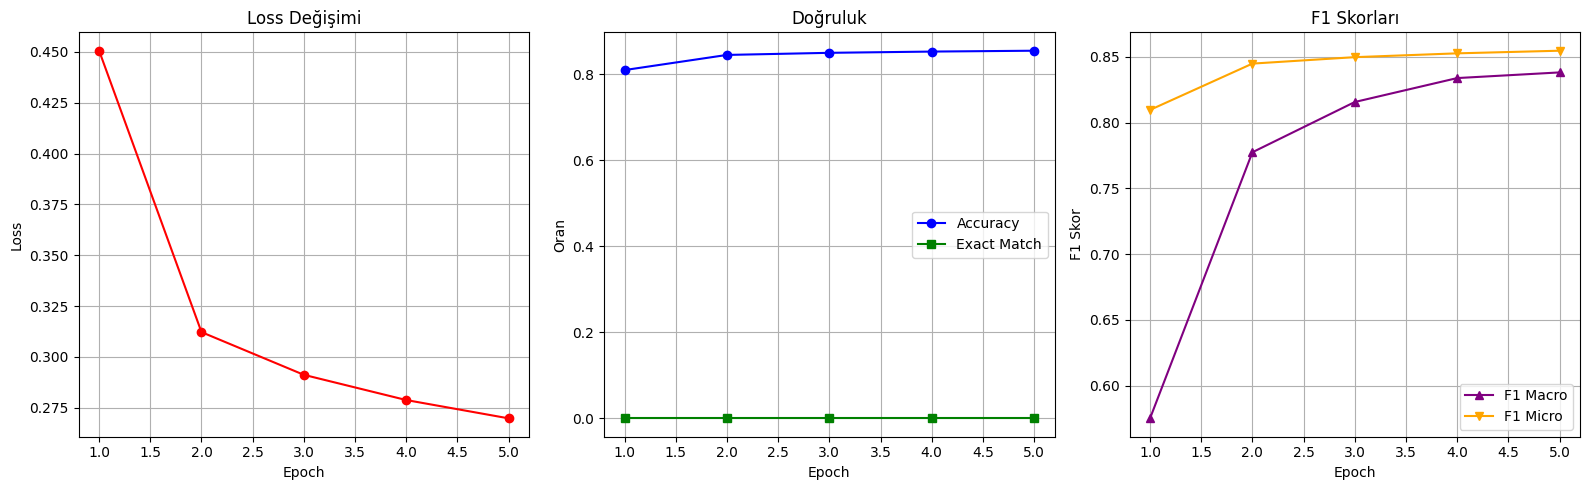

In [6]:
loss_list = [0.4506, 0.3122, 0.2912, 0.2788, 0.2698]
acc_list = [0.8096, 0.8448, 0.8497, 0.8526, 0.8546]
f1_macro_list = [0.5751, 0.7774, 0.8156, 0.8338, 0.8381]
f1_micro_list = [0.8096, 0.8448, 0.8497, 0.8526, 0.8546]
exact_match_list = [0.0, 0.0, 0.0, 0.0, 0.0]  
epochs = range(1, 6)

import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))

# Loss Grafiği
plt.subplot(1,3,1)
plt.plot(epochs, loss_list, marker='o', color='red')
plt.title('Loss Değişimi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Accuracy ve Exact Match
plt.subplot(1,3,2)
plt.plot(epochs, acc_list, marker='o', label='Accuracy', color='blue')
plt.plot(epochs, exact_match_list, marker='s', label='Exact Match', color='green')
plt.title('Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Oran')
plt.legend()
plt.grid(True)

# F1-skorları
plt.subplot(1,3,3)
plt.plot(epochs, f1_macro_list, marker='^', label='F1 Macro', color='purple')
plt.plot(epochs, f1_micro_list, marker='v', label='F1 Micro', color='orange')
plt.title('F1 Skorları')
plt.xlabel('Epoch')
plt.ylabel('F1 Skor')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Değerlendirme Metrikleri Açıklamaları

| Metrik       | Açıklama                                                                                                                                                   |
|--------------|------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Epoch**    | Modelin eğitiminin kaçıncı tekrarında (turunda) ölçüm yapıldığını belirtir.                                                                                |
| **Loss**     | Modelin tahmin hatasını gösteren bir sayı. Düşük olması, modelin tahminlerinin daha doğru olduğunu gösterir.                                               |
| **Accuracy** | Karakter bazında doğruluk oranı. Tüm tahmin edilen karakterlerin yüzde kaçı doğru bulunmuş?                                                                |
| **ExactMatch** | Tam kelime doğruluğu: Bir kelimenin tüm harfleri eksiksiz doğruysa 1, değilse 0 olarak hesaplanır. Ortalama alındığında, modelin harfi harfine tam doğru çevirdiği kelimelerin oranını verir. |
| **F1_macro** | Her harf sınıfı için hesaplanan F1 skorlarının ortalamasıdır. Hem yaygın hem de nadir görülen harflerin doğruluk ve hassasiyetini birlikte ölçer.          |
| **F1_micro** | Tüm harfler için genel F1 skorudur. Modelin tüm karakterlerdeki genel başarısını özetler, genellikle accuracy ile çok yakın bir değerdir.                  |


#### Daha kısa özetle:

- **Epoch:** Eğitimdeki tekrar sayısı 
- **Loss:** Modelin ortalama tahmin hatası (ne kadar düşükse o kadar iyi).
- **Accuracy:** Karakter başına genel doğruluk.
- **ExactMatch:** Tüm harfleri eksiksiz doğru tahmin edilen kelime oranı.
- **F1_macro:** Her karakter sınıfı için ortalama doğruluk ve duyarlılık (hem sık hem nadir harfler eşit ağırlıkta).
- **F1_micro:** Tüm karakterler üzerinde toplam başarı 


### Eğitim Süreci Metrik Tablosu

| Epoch | Loss   | Accuracy | ExactMatch | F1_macro | F1_micro |
|-------|--------|----------|------------|----------|----------|
| 1     | 0.4506 | 0.8096   | 0.0        | 0.5751   | 0.8096   |
| 2     | 0.3122 | 0.8448   | 0.0        | 0.7774   | 0.8448   |
| 3     | 0.2912 | 0.8497   | 0.0        | 0.8156   | 0.8497   |
| 4     | 0.2788 | 0.8526   | 0.0        | 0.8338   | 0.8526   |
| 5     | 0.2698 | 0.8546   | 0.0        | 0.8381   | 0.8546   |

#### Tablo Üzerine Yorum

- **Loss** değeri, her epoch'ta  düzenli olarak azalmıştır. Bu durum, modelin tahminlerinde daha az hata yapmaya başladığını ve öğrenmenin başarıyla ilerlediğini gösterir.
- **Accuracy** başlangıçta %80.96 iken, eğitim sonunda %85.46'ya ulaşmıştır. Bu, modelin karakter bazında oldukça başarılı olduğunu gösterir.
- **F1_macro** ve **F1_micro** skorları, modelin hem sık görülen hem de nadir harflerde iyi performans sergilediğini ve genel doğruluğunun yüksek olduğunu gösterir. F1_macro değeri epoch başında 0.57 iken, eğitim sonunda 0.83'e yükselmiştir.
- **ExactMatch** değeri burada eğitim sırasında sıfır olarak kalmış, çünkü bu metrik tipik olarak modelin test veya doğrulama verisi üzerinde, tüm kelimenin eksiksiz doğru tahmin edilip edilmediğini ölçmek için ayrı bir aşamada hesaplanır.
- Sonuç olarak, eğitim boyunca kayıp (loss) azalmış ve doğruluk oranları sürekli yükselmiştir. Model, karakter bazında %85'in üzerinde başarıya ulaşmıştır.




In [ ]:
import pandas as pd
df_metrics = pd.DataFrame({
    'Epoch': list(epochs),
    'Loss': loss_list,
    'Accuracy': acc_list,
    'ExactMatch': exact_match_list,
    'F1_macro': f1_macro_list,
    'F1_micro': f1_micro_list
})
display(df_metrics)


,Epoch,Loss,Accuracy,ExactMatch,F1_macro,F1_micro
0,1,0.4506,0.8096,0.0,0.5751,0.8096
1,2,0.3122,0.8448,0.0,0.7774,0.8448
2,3,0.2912,0.8497,0.0,0.8156,0.8497
3,4,0.2788,0.8526,0.0,0.8338,0.8526
4,5,0.2698,0.8546,0.0,0.8381,0.8546
